Import required library

In [3]:
import pandas as pd
import numpy as np
import re
import collections
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import keras
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle


Read dataset 

In [5]:
df = pd.read_csv("spam.csv", encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1, inplace=True)

In [8]:
df.groupby(['v1']).size()

v1
ham     4825
spam     747
dtype: int64

Value count plot

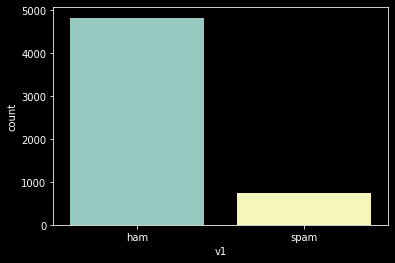

In [11]:
sns.countplot(df.v1)

In [16]:
df.columns = ["Col1","Col2"]

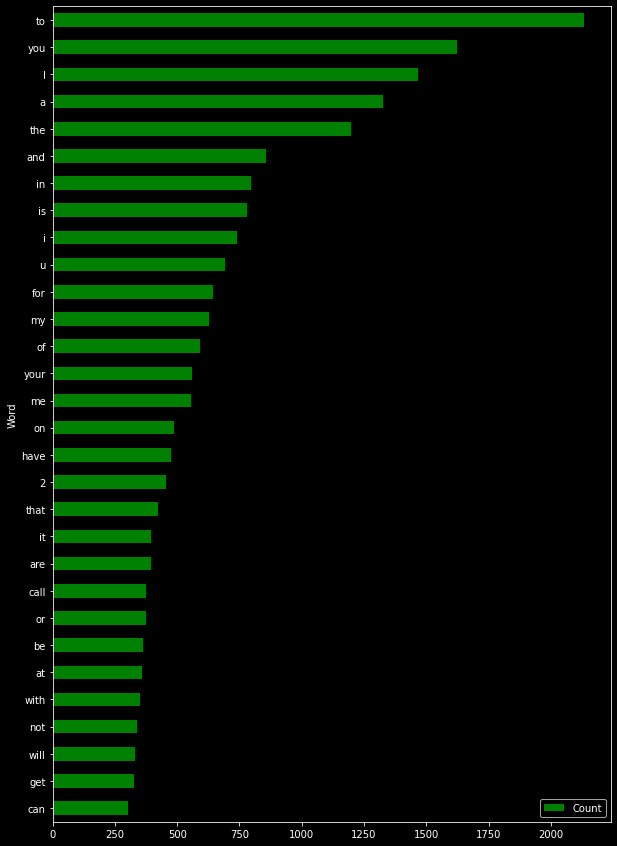

In [17]:
def word_count_plot(df):
     word_counter = collections.Counter([word for sentence in df for word in sentence.split()])
     most_count = word_counter.most_common(30) 
     most_count = pd.DataFrame(most_count, columns=["Word", "Count"]).sort_values(by="Count")
     most_count.plot.barh(x = "Word", y = "Count", color="green", figsize=(10, 15))
word_count_plot(df["Col2"])

Pre-processing techniques

In [21]:
!pip install contractions
import contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [36]:
lem = WordNetLemmatizer()
def preprocessing(data):
      sms = contractions.fix(data) 
      sms = sms.lower() 
      sms = re.sub(r'https?://S+|www.S+', "", sms).strip() 
      sms = re.sub("[^a-z ]", "", sms) 
      sms = sms.split()
      #lemmatization and stopword removal
      sms = [lem.lemmatize(word) for word in sms if not word in set(stopwords.words("english"))]
      sms = " ".join(sms)
      return sms
X = df['Col2'].apply(preprocessing)

Categorical to numerical form

In [38]:
from sklearn.preprocessing import LabelEncoder
lb_enc = LabelEncoder()
y = lb_enc.fit_transform(df["Col1"])

Tokenize data to convert it into numerical sequence 

In [39]:
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(X)
text_to_sequence = tokenizer.texts_to_sequences(X) 

In [40]:
for i in range(5):
           print("Text               : ",X[i] )
           print("Numerical Sequence : ", text_to_sequence[i])

Text               :  go jurong point crazy available bugis n great world la e buffet cine got amore wat
Numerical Sequence :  [3, 3575, 255, 549, 522, 1028, 35, 56, 236, 845, 80, 2411, 1029, 9, 3576, 70]
Text               :  ok lar joking wif oni
Numerical Sequence :  [6, 220, 1173, 328, 1539]
Text               :  free entry wkly comp win fa cup final tkts st may text fa receive entry questionstd txt ratetcs apply over
Numerical Sequence :  [5, 342, 582, 724, 92, 1540, 846, 478, 1541, 147, 175, 17, 1540, 221, 342, 2412, 23, 2413, 263, 2414]
Text               :  dun say early hor c already say
Numerical Sequence :  [142, 48, 256, 2415, 69, 75, 48]
Text               :  nah think go usf life around though
Numerical Sequence :  [774, 33, 3, 725, 86, 121, 195]


In [41]:
tokenizer.index_word 

{1: 'call',
 2: 'get',
 3: 'go',
 4: 'know',
 5: 'free',
 6: 'ok',
 7: 'ltgt',
 8: 'day',
 9: 'got',
 10: 'want',
 11: 'come',
 12: 'like',
 13: 'love',
 14: 'going',
 15: 'good',
 16: 'time',
 17: 'text',
 18: 'send',
 19: 'message',
 20: 'need',
 21: 'one',
 22: 'today',
 23: 'txt',
 24: 'home',
 25: 'lor',
 26: 'see',
 27: 'sorry',
 28: 'stop',
 29: 'r',
 30: 'still',
 31: 'back',
 32: 'mobile',
 33: 'think',
 34: 'reply',
 35: 'n',
 36: 'take',
 37: 'tell',
 38: 'phone',
 39: 'new',
 40: 'week',
 41: 'later',
 42: 'da',
 43: 'hi',
 44: 'please',
 45: 'cannot',
 46: 'make',
 47: 'tomorrow',
 48: 'say',
 49: 'night',
 50: 'claim',
 51: 'well',
 52: 'thing',
 53: 'much',
 54: 'dear',
 55: 'oh',
 56: 'great',
 57: 'hey',
 58: 'pls',
 59: 'would',
 60: 'give',
 61: 'number',
 62: 'way',
 63: 'happy',
 64: 'friend',
 65: 'work',
 66: 'hope',
 67: 'u',
 68: 'let',
 69: 'c',
 70: 'wat',
 71: 'prize',
 72: 'right',
 73: 'yes',
 74: 'min',
 75: 'already',
 76: 'ask',
 77: 'really',
 78: 'yea

In [44]:
max_length_sequence = max([len(i) for i in text_to_sequence])
padded_sms_sequence = pad_sequences(text_to_sequence, maxlen=max_length_sequence, 
                                    padding = "pre") 
padded_sms_sequence

array([[   0,    0,    0, ...,    9, 3576,   70],
       [   0,    0,    0, ..., 1173,  328, 1539],
       [   0,    0,    0, ..., 2413,  263, 2414],
       ...,
       [   0,    0,    0, ..., 1024, 7818, 3573],
       [   0,    0,    0, ...,  789,   67,    5],
       [   0,    0,    0, ..., 2147,  363,  145]], dtype=int32)

Create model and add layers

In [45]:
TOT_SIZE = len(tokenizer.word_index)+1
def create_model():
    
      lstm_model = Sequential()
      lstm_model.add(Embedding(TOT_SIZE, 32, input_length=max_length_sequence))
      lstm_model.add(LSTM(100))
      lstm_model.add(Dropout(0.4))
      lstm_model.add(Dense(20, activation="relu"))
      lstm_model.add(Dropout(0.3))
      lstm_model.add(Dense(1, activation = "sigmoid"))
      return lstm_model
lstm_model = create_model()
lstm_model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])


In [46]:
lstm_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 79, 32)            250240    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 20)                2020      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 305,481
Trainable params: 305,481
Non-tr

Fit model

In [47]:
lstm_model.fit(padded_sms_sequence, y, epochs = 5, validation_split=0.2, batch_size=16)

Epoch 1/5
279/279 [==============================] - 12s 36ms/step - loss: 0.2294 - accuracy: 0.9322 - val_loss: 0.0658 - val_accuracy: 0.9794
Epoch 2/5
279/279 [==============================] - 12s 42ms/step - loss: 0.0464 - accuracy: 0.9892 - val_loss: 0.0656 - val_accuracy: 0.9758
Epoch 3/5
279/279 [==============================] - 10s 35ms/step - loss: 0.0195 - accuracy: 0.9953 - val_loss: 0.0793 - val_accuracy: 0.9848
Epoch 4/5
279/279 [==============================] - 10s 37ms/step - loss: 0.0103 - accuracy: 0.9978 - val_loss: 0.0896 - val_accuracy: 0.9749
Epoch 5/5
279/279 [==============================] - 10s 35ms/step - loss: 0.0044 - accuracy: 0.9991 - val_loss: 0.1009 - val_accuracy: 0.9776


Save the model

In [49]:
lstm_model.save('Spam_classifier.h5')

Test The Model

In [51]:
from sklearn.model_selection import train_test_split

In [52]:
X = df.Col2
Y = df.Col1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [53]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

In [60]:
test_sequences=tok.texts_to_sequences(X_test)
test_sequences_matrix=pad_sequences(test_sequences,maxlen=max_len)


In [61]:
accuracy = lstm_model.evaluate(test_sequences_matrix,Y_test)

27/27 [==============================] - 1s 18ms/step - loss: 1.5697 - accuracy: 0.8242
